<a href="https://colab.research.google.com/github/fedhere/PUS2022_FBianco/blob/main/HW4/Geospatial_NYCCitiBike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# reproducible Spatial Data Analysis with pandas
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

Use this notebook we examined in class 
https://github.com/fedhere/PUS2022_FBianco/blob/main/classdemo/PhillyCitiBikes_partiallyFilledNotebook.ipynb

as well as the notebooks we wrote together 
https://github.com/fedhere/PUS2022_FBianco/blob/main/classdemo/Part_I_GeospatialAnalysis_CitiBike.ipynb

# 0 Install geospatial libraries

In [ ]:
#delete
!pip install geopandas
!pip install rtree 


## 0.1 Import initial libraries

In [ ]:
#delete
import geopandas as gpd
import shapely
import pandas as pd
import pylab as plt

# 1 Working with a Shape File of Census Tracts

### 1.1 Loading Census Tract GeoJSON File


In [ ]:
ct_shape = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=GeoJSON")

In [ ]:
ct_shape.info()

## 1.2 Coordinate systems, projections, and transformations : 

### Visualize the Census Tract boundaries colored by boroughs

the file you read in into a geodataframe, which I will call generically ```gpd``` in these instructions, contains the "boro_code" column. To color by a column value (and the column can be numerical or categorical) you pass the column name to ```gdp.plot``` as
```gdp.plot(column="columnName")```

In [ ]:
f, ax = plt.subplots(figsize=(8,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#ax.set_xlabel(...)
#ax.set_ylabel(...)
ct_shape.plot(column='boro_code', alpha=1, linewidth=0.5,
              ax=ax, cmap='Paired')
plt.title("Census Tract map colored by boroughs");

### Measure Areas

As discussed in class, you cannot use coordinates in latitude and longitude degree units to measure areas of polygons: you need first to project on a plane.

* Convert the coordinates of  your geodataframe, here referred to  as gpd, to a projected EPSG:2263 which is coordinated in feet, instead of lat long degrees. centered near NYC

  use 

```gpd.to_crs("EPSG:2263")```

* Extract the area of each gemetry : the geometry column has many relevant methods. use (as we did in class)

```gpd.geometry.area```

* Create a new column in your dataframe called "shape_areami2" and set it equal to the area of the polygon in miles squared. the feet to miles conversion is here 
https://www.google.com/search?sxsrf=ALeKk03B4ThQrJJXpFzoCrgRfrJ1nByPMg%3A1600870977934&ei=QVprX9muOIOl_QbOtaOwCQ&q=feet+to+mile&oq=feet+to+mile&gs_lcp=CgZwc3ktYWIQAzIICAAQsQMQkQIyAggAMgIIADICCAAyAggAMgIIADICCAAyAggAMgIIADICCAA6BAgAEEc6BAgjECc6BQgAELEDOgoIABCxAxAUEIcCUM_1AVjK-AFgzPoBaABwAngAgAFkiAHvApIBAzMuMZgBAKABAaoBB2d3cy13aXrIAQjAAQE&sclient=psy-ab&ved=0ahUKEwiZ0-GPvf_rAhWDUt8KHc7aCJYQ4dUDCA0&uact=5


* Calculate the total area of NYC in miles squared. 

* On epsg.io  look up the EPSG:2263. What is the accuracy when this projection is used in NYC?



In [ ]:
#delete
ct_shape = ct_shape.to_crs("EPSG:2263")

In [ ]:
#delete
ct_shape["shape_areami2"] = ct_shape.geometry.area * 0.000189394 * 0.000189394
NYC_Area = ct_shape["shape_areami2"].sum() 
print ('total NYC land area: {:.0f} (mi^2)'.format(NYC_Area)) # from ft2 to mi2 #epsg=2263 is US feet

### Choropleths of NYC

a choropleth is a map where the color of a polygon is mapped to a value. Perhaps the easiest thing to envision is to map the color to the size of the polygon. To make a choropleth of your python geodataframe (gdp) you can use, like before but this time with a numerical column:

```gdp.plot(column="theNameOfMyColumn")```

The problem is that the column has to be numeric. I want you to use "shape_area" but "shape_area" is not directly read in as a numerical column (you can tell when you run gdp.info(): it says its a type "object").

Convert gdp["shape_area"] to numeric by passing it to the pandas function

```pd.to_numeric()``` with the argument 

```error="coerce"```

https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html

In [ ]:
ct_shape.info()

In [ ]:
ct_shape["shape_area"] = pd.to_numeric(ct_shape["shape_area"], errors='coerce')


In [ ]:
ax = ct_shape.plot(column="shape_area")
ax.axis('off');

Now use your column "shape_areami2" - the colors should be mapped the same way

In [ ]:
ax = ct_shape.plot(column="shape_areami2")
ax.axis('off');

Now lets put some numerical values to the colors. you can do by adding the argument 

```legend=True```

 to the choropleth gdp.plot() call

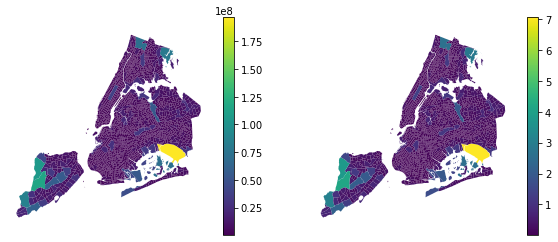

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ct_shape.plot(column="shape_area", legend=True, ax=ax)
ax.axis('off');
ax = fig.add_subplot(122)
ct_shape.plot(column="shape_areami2", legend=True, ax=ax)
ax.axis('off');

Often a more useful way to read numers associated to colors is to use quantiles. For this yuo need to install 

```mapclassify```

In [ ]:
!pip install mapclassify

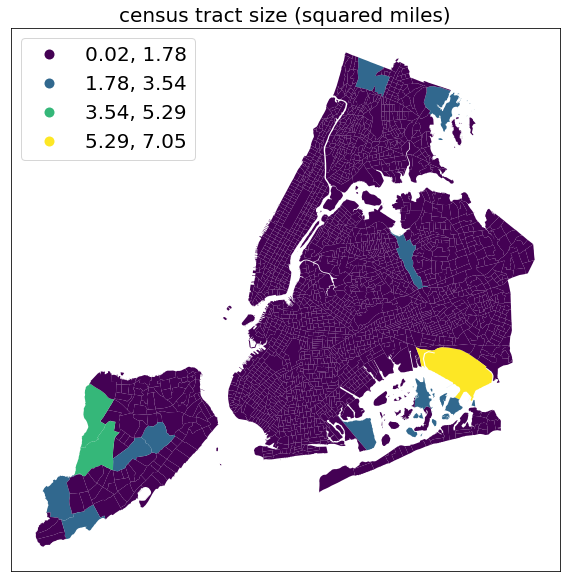

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='shape_areami2', cmap='viridis', alpha=1,
              linewidth=0.1, ax=ax, scheme="Equal_interval", 
              legend=True, k=4, legend_kwds={'loc': 'upper left', 'fontsize':20});
plt.title("census tract size (squared miles)", fontsize=20);

(At some point i got so tired of moving the legend around that i made a whole package to plot choropleths of NYC https://github.com/fedhere/choroplethNYC )

# 2 Explore CitiBike data

### 2.1 Load CitiBike data for 9/2013

In [ ]:
cb201609 = pd.read_csv('https://s3.amazonaws.com/tripdata/201609-citibike-tripdata.zip', index_col='starttime')
cb201609.head()

## 2.2 Explore the dataset, you know how!

In [ ]:
...

## 2.3 Map CitiBike Data at the census tract level

### Create a stations dataframe with spatial info
 
this is done alrady in the notebook we reviewed in class. The steps are:

* groupby station and take the first row of wach group with 

```gdp.groupby("...").first()```

* call your new dataframe "cbstations"

In [ ]:
cbstations = cb201609.groupby("start station id").first()
cbstations.head()

,tripduration,stoptime,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
start station id,,,,,,,,,,,,,
72,944,9/1/2016 00:41:52,W 52 St & 11 Ave,40.767272,-73.993929,453,W 22 St & 8 Ave,40.744751,-73.999154,22738,Subscriber,1989.0,2
79,303,9/1/2016 07:13:30,Franklin St & W Broadway,40.719116,-74.006667,152,Warren St & Church St,40.714740,-74.009106,19043,Subscriber,1984.0,2
82,208,9/1/2016 00:46:55,St James Pl & Pearl St,40.711174,-74.000165,331,Pike St & Monroe St,40.711731,-73.991930,25627,Subscriber,1989.0,1
83,301,9/1/2016 00:44:26,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,3416,7 Ave & Park Pl,40.677615,-73.973243,18079,Subscriber,1980.0,2
116,858,9/1/2016 00:15:31,W 17 St & 8 Ave,40.741776,-74.001497,116,W 17 St & 8 Ave,40.741776,-74.001497,18605,Subscriber,1988.0,1


### Create CitiBike station Geometry (Point) from Coordinates (Lat & Lon)

from each pair of latitude and longitude coordinates for the start station make a shapely Point object (see https://github.com/fedhere/PUS2022_FBianco/blob/main/classdemo/PhillyCitiBikes_partiallyFilledNotebook.ipynb)

In [ ]:
import shapely
# combine lat and lon to one column
cbstations['lonlat'] = cbstations.apply(lambda x: shapely.geometry.Point(
    x["start station longitude"], x["start station latitude"]), axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [ ]:
cbstations.head()

,tripduration,stoptime,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,lonlat
start station id,,,,,,,,,,,,,,
72,944,9/1/2016 00:41:52,W 52 St & 11 Ave,40.767272,-73.993929,453,W 22 St & 8 Ave,40.744751,-73.999154,22738,Subscriber,1989.0,2,POINT (-73.99392888 40.76727216)
79,303,9/1/2016 07:13:30,Franklin St & W Broadway,40.719116,-74.006667,152,Warren St & Church St,40.714740,-74.009106,19043,Subscriber,1984.0,2,POINT (-74.00666661 40.71911552)
82,208,9/1/2016 00:46:55,St James Pl & Pearl St,40.711174,-74.000165,331,Pike St & Monroe St,40.711731,-73.991930,25627,Subscriber,1989.0,1,POINT (-74.00016545 40.71117416)
83,301,9/1/2016 00:44:26,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,3416,7 Ave & Park Pl,40.677615,-73.973243,18079,Subscriber,1980.0,2,POINT (-73.97632328 40.68382604)
116,858,9/1/2016 00:15:31,W 17 St & 8 Ave,40.741776,-74.001497,116,W 17 St & 8 Ave,40.741776,-74.001497,18605,Subscriber,1988.0,1,POINT (-74.00149746 40.74177603)


### plot the stations

* Turn the dataframe into a geodataframe (as I did in class in the example above)

* Every geodataframe needs a geometry column: assign latlon to the "geometry"

* Set the crs to “EPSG:4326” with 
```gdp.set_crs()```

* Plot the locations of the stations

In [ ]:
cbstations = gpd.GeoDataFrame(cbstations)
cbstations["geometry"] = cbstations.lonlat
cbstations = cbstations.set_crs("EPSG:4326")


In [ ]:
cbstations.plot();

### convert the geometry projection to the same one you used for the NYC census tracts and replot with the censos tract map in the background


In [ ]:
cbstations = cbstations.to_crs("EPSG:2263")

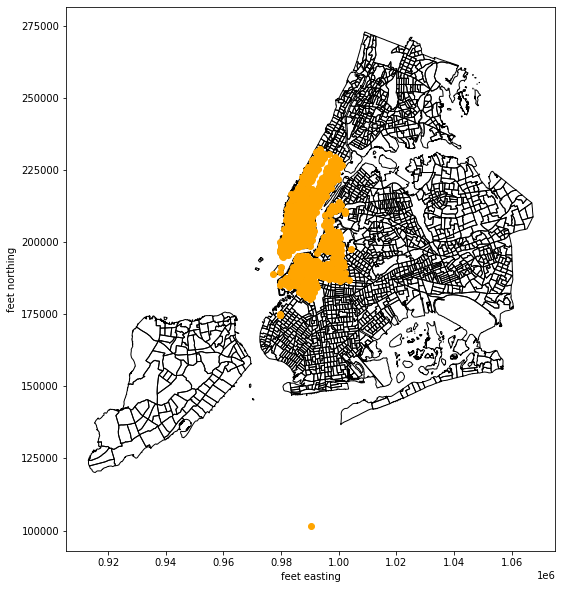

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("feet easting")
ax.set_ylabel("feet northing")
#ct_shape.boundary.plot(ax=ax, alpha=0.5)
ct_shape.plot(ax=ax, color="None", edgecolor='k')
cbstations.plot(ax=ax, c='orange');

### cleaning data

Clearly there is an data stored incorrectly: that station at the bottom is in the water. Remove it by selecting "start station latitude" greater than some appropriate value and replot

In [ ]:
cbstations = cbstations[cbstations["start station latitude"] > 40.6]

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("feet easting")
ax.set_ylabel("feet northing")
#ct_shape.boundary.plot(ax=ax, alpha=0.5)
ct_shape.plot(ax=ax, color="None", edgecolor='k')
cbstations.plot(ax=ax, c='orange');

### zoom into the relevant area 

zoom-in into the relevant area using ```ax.set_xlim()``` and ```ax.set_ylim()```

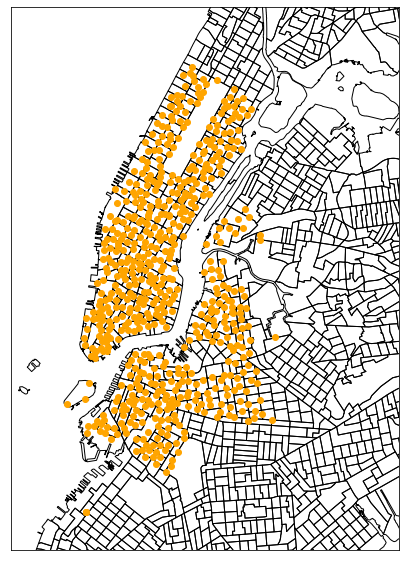

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(ax=ax, color="None", edgecolor='k')
cbstations.plot(ax=ax, c='orange');
ax.set_xlim(0.97e6, 1.02e6)
ax.set_ylim(170000, 240000);

# 3 Assigning points to polygons


## 3.1 Assign each station to a Borough

### Intrsect the census tract and citi bikes geometries manually

``` gdp.ct_shape.geometry.intersect```

First, let me do this by intersecting the shapes "manually" in a for loop. This should be transparent as far as the syntax go but it is very computationally inefficient


In [ ]:
cbstations["boro_name"] = ''
# check for each citibike stations to see what CT they are belong to
for i in cbstations.index:
    a = ct_shape[ct_shape.geometry.intersects(
        cbstations.loc[i].geometry)]["boro_name"].values[0]
    
    cbstations.loc[i,'boro_name'] = a


In [ ]:
cbstations.head()

### overplot the map locations on top of the census tract boundaries in the zoom in version (as before) but this time color the points by NYC Borough

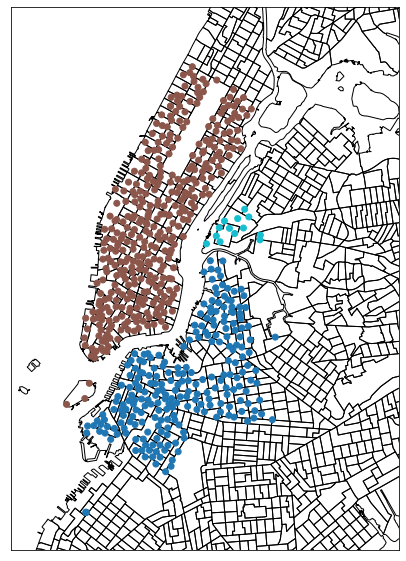

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(ax=ax, color="None", edgecolor='k')
cbstations.plot(column="boro_name", ax=ax);
ax.set_xlim(0.97e6, 1.02e6)
ax.set_ylim(170000, 240000);

## 3.2 create a colopleth of NYC census tracts where the color maps to the number of citibike stations


### Perform a spatial join

Perfoming an $n \times m$ intersection test is horrifically inefficient and slow. Spatial joins use an R-tree for spatial indexing to rapidly join the tables on their geometries. 

Spatial joins operate on objects with eastings and northings, i.e., you must use two geodataframs with the same CRS, and that needs ot be a CRS expressed with dimensioned lengths. This will NOT work on data expressed in lat/long.

use 

```geopandas.tools.sjoin()``` 
passing to it ct_shape and cbstations to get a dataframe that for every station row has the census tract value in a ```boro_ct2010``` column

In [ ]:
cbstationsWct = gpd.tools.sjoin(ct_shape, cbstations)
cbstationsWct

,ntacode,shape_area,ntaname,shape_leng,boro_name_left,puma,ct2010,boro_code,cdeligibil,boro_ct2010,...,end station latitude,end station longitude,bikeid,usertype,birth year,gender,lonlat,boro_ct201,ct,boro_name_right
1,MN19,1.906016e+06,Turtle Bay-East Midtown,5534.20030825,Manhattan,3808,009800,1,I,1009800,...,40.771404,-73.953517,19938,Customer,1990.0,0,POINT (-73.96592976 40.75455731),Manhattan,,Manhattan
1,MN19,1.906016e+06,Turtle Bay-East Midtown,5534.20030825,Manhattan,3808,009800,1,I,1009800,...,40.720196,-73.989978,15618,Subscriber,1992.0,1,POINT (-73.967416 40.756014),Manhattan,,Manhattan
2,MN17,1.860993e+06,Midtown-Midtown South,5687.80243891,Manhattan,3807,010200,1,I,1010200,...,40.771522,-73.990541,24994,Subscriber,1965.0,1,POINT (-73.97402311 40.7597108),Manhattan,,Manhattan
2,MN17,1.860993e+06,Midtown-Midtown South,5687.80243891,Manhattan,3807,010200,1,I,1010200,...,40.760958,-73.967245,25802,Subscriber,1986.0,1,POINT (-73.972924 40.761628),Manhattan,,Manhattan
3,MN17,1.864600e+06,Midtown-Midtown South,5693.03636707,Manhattan,3807,010400,1,I,1010400,...,40.764397,-73.973715,20969,Subscriber,1986.0,1,POINT (-73.97648516 40.75992262),Manhattan,,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,BK99,2.740340e+07,park-cemetery-etc-Brooklyn,24250.8583554,Brooklyn,4005,017700,3,I,3017700,...,40.668132,-73.973638,19360,Customer,1979.0,0,POINT (-73.97363831 40.668132),Brooklyn,,Brooklyn
2150,MN17,2.434388e+06,Midtown-Midtown South,6254.84415438,Manhattan,3807,013700,1,I,1013700,...,40.690893,-73.996123,19425,Subscriber,1982.0,1,POINT (-73.98192338 40.7652654),Manhattan,,Manhattan
2150,MN17,2.434388e+06,Midtown-Midtown South,6254.84415438,Manhattan,3807,013700,1,I,1013700,...,40.777507,-73.988886,19303,Subscriber,1982.0,1,POINT (-73.98169333 40.76695317),Manhattan,,Manhattan
2151,MN15,1.954944e+06,Clinton,5774.68293551,Manhattan,3807,013900,1,I,1013900,...,40.764618,-73.987895,16842,Subscriber,1983.0,1,POINT (-73.988639 40.768254),Manhattan,,Manhattan


### groupby the geodataframe resulting from the spatial join grouping based on the census tract (e.g. use "boro_ct2010") and _count_ the number of station per boro_ct2010 value



### merge the geodataframe resulting from the spatial join + groupby  with the original census tract geodataframe. NOTE: you should remove the geometry column from the first dataframe before you merge cause you want the geometry to be inherited from the census tracts geodataframe. In fact, from the first geodataframe, you need _only_ one column that contains the number of stations for that geometry group

### plot the census tracts in the background (in black and white) and overplot a coropleth of the number of stations per census tract: the latter is the geodataframe you produced above plotted with the column argument set to the column name of the column that contains the number of stations information

.... YOU ARE DONE!!

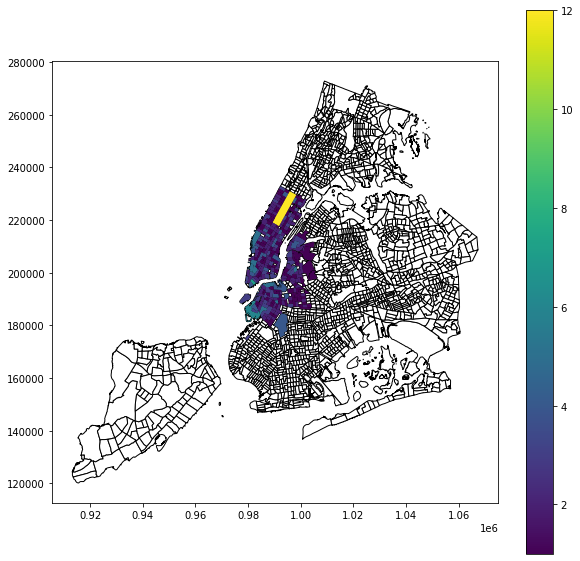

In [ ]:
ax = ct_shape.plot(ec="k", fc="w", figsize=(10,10))
ct_shape.merge(cbstationsWct.groupby("boro_ct2010").count()[["ntacode"]], right_index=True, left_on="boro_ct2010").plot(column="ntacode_y", legend=True, ax=ax)